#### Creating different models on TataMotors stock for prediction.

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

In [40]:
warnings.filterwarnings('ignore')

In [4]:
ticker = yf.Ticker('TATAMOTORS.NS')

In [5]:
data = ticker.history(start= '2012-07-15', end= '2022-07-21')
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-07-16,228.189976,228.958610,219.638852,220.263367,8741929,0.000000,0
2012-07-17,222.809490,223.241847,216.420163,217.044693,12015166,0.000000,0
2012-07-18,218.854191,219.000923,213.621264,216.751236,11897419,3.957551,0
2012-07-19,219.587792,221.544030,218.903099,219.881226,6677436,0.000000,0
2012-07-20,219.098738,220.517000,217.191406,218.511856,3940979,0.000000,0


In [6]:
data.shape

(2468, 7)

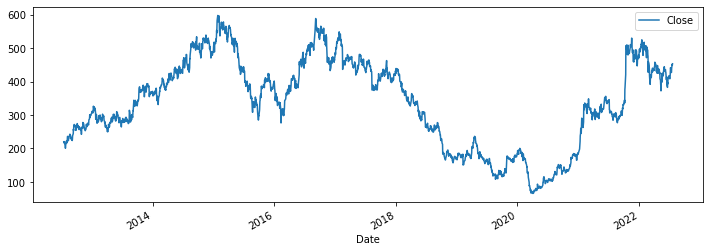

In [8]:
data.Close.plot(figsize=(12,4));
plt.legend();

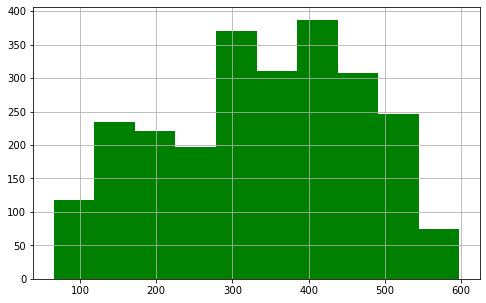

In [9]:
data.Close.hist(figsize=(8,5), color= 'green');

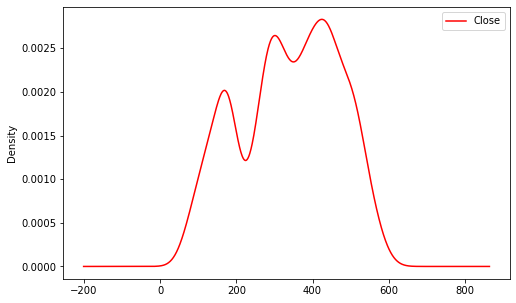

In [10]:
data.Close.plot(kind= 'kde', figsize= (8,5), legend='Close', color= 'red');

In [11]:
data.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2468 entries, 2012-07-16 to 2022-07-20
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2468 non-null   float64
 1   High          2468 non-null   float64
 2   Low           2468 non-null   float64
 3   Close         2468 non-null   float64
 4   Volume        2468 non-null   int64  
 5   Dividends     2468 non-null   float64
 6   Stock Splits  2468 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 154.2 KB


### Identifying Non Stationary Data :- 

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

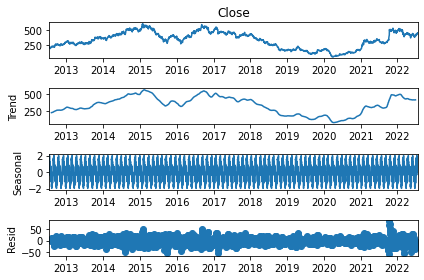

In [14]:
decompose_ts_add = seasonal_decompose(data.Close,period=30)
decompose_ts_add.plot()
plt.show()

### ADF (Augmented Dicker Fuller) Test :-
+ To check if the data is stationary or not
+ If pvalue is less than alpha we assume data is not stationary and if its less than alpha then data is stationary

In [15]:
from statsmodels.tsa.stattools import adfuller

#### Customized function for adf test to check for stationary :- 

In [16]:
def adf_test(series):
    test = adfuller(series)
    labels = ['Test Statistic','p-value','#Lags Used','Number of Observations Used','Critical Values']
    for key,value in zip(labels,test):
        print(key,":",value)

#### Testing Closing Price data for stationarity :- 

In [17]:
adf_test(data.Close)

Test Statistic : -1.6160372742872937
p-value : 0.47480740490133805
#Lags Used : 0
Number of Observations Used : 2467
Critical Values : {'1%': -3.4330034727471475, '5%': -2.8627122832725975, '10%': -2.567394052950918}


### As per the adfuller test we see that p-value is greather than alpha (0.05) we failed to reject null hypothesis. We can conclude that data is not stationary.

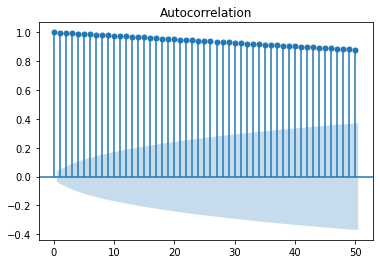

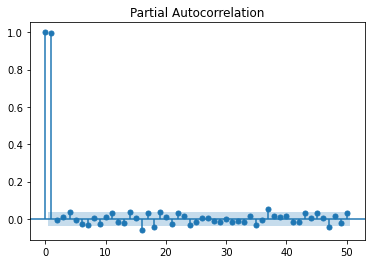

In [18]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Close,lags=50);
tsa_plots.plot_pacf(data.Close,lags=50);

#### As per the ACF plot lags are not degrading to 0 quickly which shows the signs of non-stationarity.

In [19]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np


### Transformation and evaluating if data is stationary after transformation :- 

In [21]:
df_log = np.log(data['Close']) # Log Transformation
df_sqrt = np.sqrt(data['Close']) # Square Root Transformation
df_cbrt = np.cbrt(data['Close']) # Cube Root Transformation

In [22]:
print(adf_test(df_log))
print("****************")
print(adf_test(df_sqrt))
print("****************")
print(adf_test(df_cbrt))

Test Statistic : -1.3720087819527969
p-value : 0.5956194854717931
#Lags Used : 0
Number of Observations Used : 2467
Critical Values : {'1%': -3.4330034727471475, '5%': -2.8627122832725975, '10%': -2.567394052950918}
None
****************
Test Statistic : -1.4509094313891524
p-value : 0.5576410844341798
#Lags Used : 0
Number of Observations Used : 2467
Critical Values : {'1%': -3.4330034727471475, '5%': -2.8627122832725975, '10%': -2.567394052950918}
None
****************
Test Statistic : -1.4121235910777294
p-value : 0.5764503139433919
#Lags Used : 0
Number of Observations Used : 2467
Critical Values : {'1%': -3.4330034727471475, '5%': -2.8627122832725975, '10%': -2.567394052950918}
None


+ Closing Price of the stock is still non-stationary after doing transformations. 
+ Therefore, creating a customized function to check for optimum model order for ARIMA.

# Partition Series :- 

In [23]:
dataset = data.Close.values
train_size = int(len(dataset) * 0.75)
train, test = dataset[:train_size], dataset[train_size:]
print(train.shape, test.shape)

(1851,) (617,)


# ARIMA :- 

#### Customize function for optimum model order :- 

In [171]:
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [172]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [174]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(data.Close.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=157.731
ARIMA(0, 0, 1) RMSE=81.999
ARIMA(0, 1, 0) RMSE=7.506
ARIMA(0, 1, 1) RMSE=7.508
ARIMA(0, 1, 2) RMSE=7.546
ARIMA(0, 2, 0) RMSE=10.499
ARIMA(0, 2, 1) RMSE=7.520
ARIMA(0, 2, 2) RMSE=7.520
ARIMA(1, 0, 0) RMSE=7.508
ARIMA(1, 0, 1) RMSE=7.510
ARIMA(1, 0, 2) RMSE=7.546
ARIMA(1, 1, 0) RMSE=7.508
ARIMA(1, 1, 1) RMSE=7.536
ARIMA(1, 1, 2) RMSE=7.539
ARIMA(1, 2, 0) RMSE=9.009
ARIMA(1, 2, 1) RMSE=7.521
ARIMA(1, 2, 2) RMSE=7.562
ARIMA(2, 0, 0) RMSE=7.510
ARIMA(2, 0, 1) RMSE=7.548
ARIMA(2, 0, 2) RMSE=7.537
ARIMA(2, 1, 0) RMSE=7.542
ARIMA(2, 1, 1) RMSE=7.547
ARIMA(2, 1, 2) RMSE=7.554
ARIMA(2, 2, 0) RMSE=8.702
ARIMA(2, 2, 1) RMSE=7.557
Best ARIMA(0, 1, 0) RMSE=7.506


#### Prepare model with optimum model order :- 

In [54]:
model = ARIMA(dataset, order = (0,1,0))
result = model.fit(disp= 0)
predict = result.predict(start= 1852, end= 2468, dynamic= True)
prediction = result.forecast(617)[0]
rmse_arima = np.sqrt(mean_squared_error(test, predict))
print("RMSE Arima :- ", rmse_arima)

RMSE Arima :-  319.017112425582


In [42]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2467
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -8753.197
Method:                           css   S.D. of innovations              8.408
Date:                Thu, 28 Jul 2022   AIC                          17510.394
Time:                        13:08:45   BIC                          17522.016
Sample:                             1   HQIC                         17514.616
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0945      0.169      0.558      0.577      -0.237       0.426


#### Predicted Values :- 

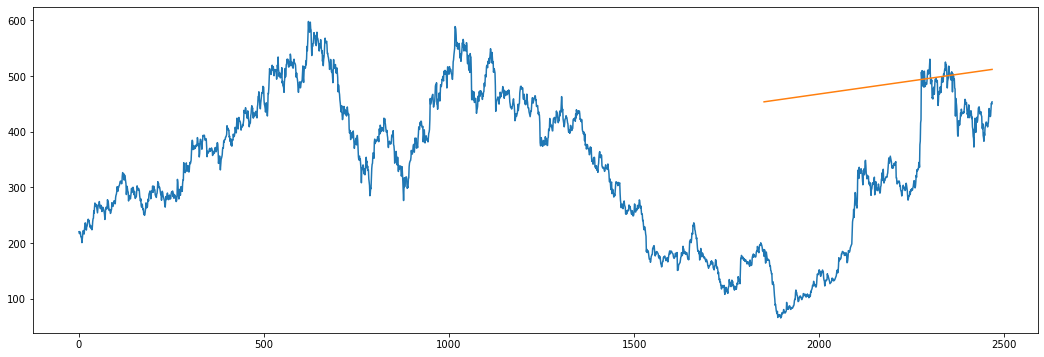

In [66]:
plt.figure(figsize = (18,6))
plt.plot(range(len(data)), data.Close, label= 'Actual');
plt.plot(range(len(data)-617, len(data)), prediction, label = 'Forecasted');